<h1>Activations gradients and batch norm</h1>

We dive deeper into some theoretical components important in building important neural networks

We first start by building the boiler plate code present in the mlp section 

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
words = open("names.txt").read().splitlines()
char_list = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(char_list)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
import random 
random.seed(42)
random.shuffle(words)

In [ ]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    chars = w + "." 
    for c in chars:
        X.append(context)
        Y.append(stoi[c])
        context = context[1:] + [stoi[c]]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
n1 = int(len(X) * 0.8)
n2 = int(len(X) * 0.9)
X_train = X[:n1]
Y_train = Y[:n1]
X_dev = X[n1:n2]
Y_dev = Y[n1:n2]
X_test = X[n2:]
Y_test = Y[n2:]


In [45]:
embeds = 10
n_hidden = 200

vocab_size = len(char_list) + 1
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embeds), generator=g)
W1 = torch.randn((embeds * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g) 

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [72]:
steps = 200000
batch_size = 32
losses = []

for i in range(steps):
    ix = torch.randint(0, len(X_train), (32,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb].view(-1, embeds * block_size)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += p.grad * -lr

    if i % 10000 == 0:
        print(i, loss)
    losses.append(loss)

0 tensor(3.6670, grad_fn=<NllLossBackward0>)
10000 tensor(2.2587, grad_fn=<NllLossBackward0>)
20000 tensor(2.1415, grad_fn=<NllLossBackward0>)
30000 tensor(2.5828, grad_fn=<NllLossBackward0>)
40000 tensor(2.3775, grad_fn=<NllLossBackward0>)
50000 tensor(2.2354, grad_fn=<NllLossBackward0>)
60000 tensor(2.2255, grad_fn=<NllLossBackward0>)
70000 tensor(1.9250, grad_fn=<NllLossBackward0>)
80000 tensor(1.9362, grad_fn=<NllLossBackward0>)
90000 tensor(1.7791, grad_fn=<NllLossBackward0>)
100000 tensor(2.2722, grad_fn=<NllLossBackward0>)
110000 tensor(1.9613, grad_fn=<NllLossBackward0>)
120000 tensor(2.2257, grad_fn=<NllLossBackward0>)
130000 tensor(2.5010, grad_fn=<NllLossBackward0>)
140000 tensor(1.9570, grad_fn=<NllLossBackward0>)
150000 tensor(2.1880, grad_fn=<NllLossBackward0>)
160000 tensor(2.1449, grad_fn=<NllLossBackward0>)
170000 tensor(1.8418, grad_fn=<NllLossBackward0>)
180000 tensor(2.3930, grad_fn=<NllLossBackward0>)
190000 tensor(2.1671, grad_fn=<NllLossBackward0>)


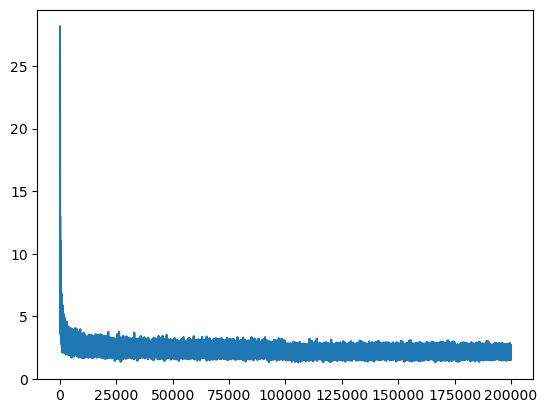

In [47]:
plt.plot([loss.item() for loss in losses])

In [55]:
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)].view(-1, embeds * block_size)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1).item()
        if ix == 0:
            break 
        out.append(itos[ix])
        context = context[1:] + [ix]
    print("".join(out))

zutorah
torie
kylo
edianel
addaline
oarhi
kashaa
aiven
lenn
markemmin
alepais
nath
adalki
mos
hommer
jenotaiceanne
ahalaydella
jama
aleigan
aeverlyn


We can tell that the network is not initialised right as the starting loss is way too high. We should effect the result to be -log(1/27) = 3.29

In [64]:
logits = torch.zeros(4)
F.softmax(logits)

/var/folders/hm/kbbhmh2175x3_lkywgvsf_4w0000gn/T/ipykernel_28399/2405175995.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logits)


tensor([0.2500, 0.2500, 0.2500, 0.2500])

A low initialisation of the weights in the final layer will make the logits almost uniform leading to a better loss that is closer to the expected result of 3.29. We thus multiply the inital weights by a scaling factor to achieve so. It is not 0 to allow for some entropy 

In [70]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embeds), generator=g)
W1 = torch.randn((embeds * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.001
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [160]:
ix = torch.randint(0, len(X_train), (32,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

emb = C[Xb].view(-1, embeds * block_size)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)
print(loss)

tensor(3.6505, grad_fn=<NllLossBackward0>)


The Tanh function squashes the values. We can observe the range of squashed values by plotting them. Not that there are 2 extremes. Most of the values are either -1 or 1 with no in between 

(array([708., 288., 198., 154., 139., 133., 105., 102.,  97.,  77., 104.,
         85.,  82.,  94.,  80.,  50.,  71.,  59.,  87.,  69.,  56.,  53.,
         55.,  58.,  72.,  52.,  66.,  54.,  65.,  73.,  58.,  57.,  59.,
         77.,  70.,  68.,  75.,  81.,  67.,  88.,  90., 107., 107., 137.,
        128., 130., 187., 234., 311., 883.]),
 array([-9.99994993e-01, -9.59995536e-01, -9.19996078e-01, -8.79996620e-01,
        -8.39997163e-01, -7.99997705e-01, -7.59998248e-01, -7.19998790e-01,
        -6.79999332e-01, -6.39999875e-01, -6.00000417e-01, -5.60000960e-01,
        -5.20001502e-01, -4.80002044e-01, -4.40002587e-01, -4.00003129e-01,
        -3.60003672e-01, -3.20004214e-01, -2.80004756e-01, -2.40005299e-01,
        -2.00005841e-01, -1.60006384e-01, -1.20006926e-01, -8.00074685e-02,
        -4.00080109e-02, -8.55326653e-06,  3.99909043e-02,  7.99903619e-02,
         1.19989820e-01,  1.59989277e-01,  1.99988735e-01,  2.39988192e-01,
         2.79987650e-01,  3.19987108e-01,  3.59986

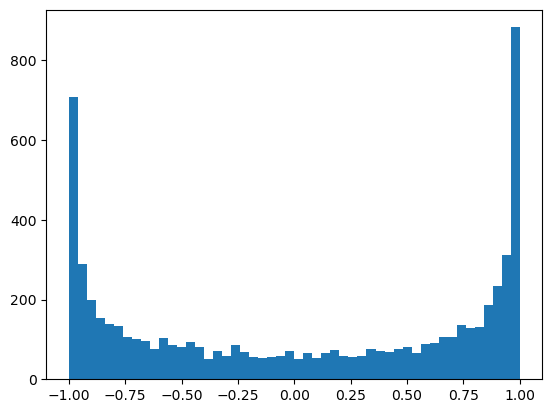

In [161]:
plt.hist(h.view(-1).tolist(), 50)

This is a problem as the local derivative of a tan h function is 1 - tanh^2. If tanh is 1 or -1 the local derivative is 0 which kills the back propagation process at that layer

We can plot the neurons that result in a tanh output of -1 or 1 to visualise the population of dead neurons. White indicates dead 

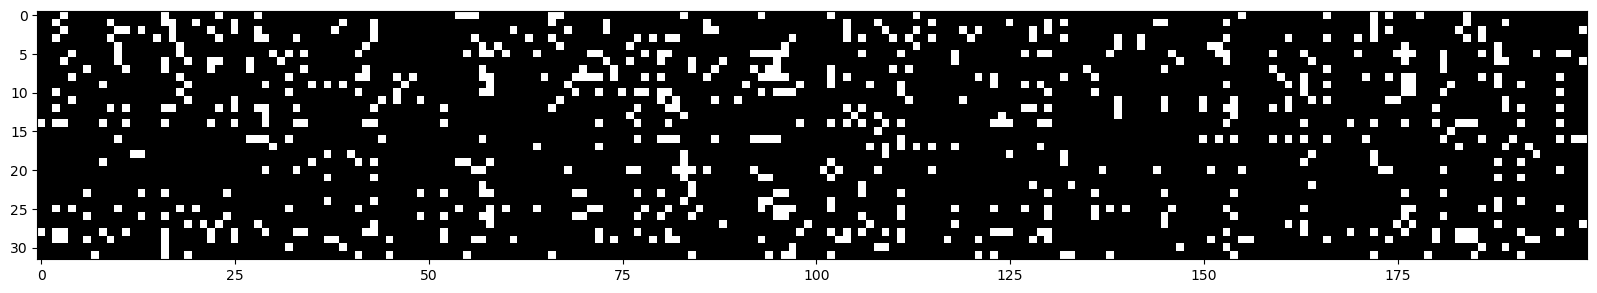

In [153]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs() > 0.99, cmap="gray")

By squashing the range weights we can reduce the pre activation of the tanh neurons which in result should reduce the amount of dead neurons. 

In [181]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embeds), generator=g)
W1 = torch.randn((embeds * block_size, n_hidden), generator=g) * (5/3) / ((embeds * block_size) ** 0.5)
b1 = torch.randn((n_hidden), generator=g) * 0.001
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g)

gain = torch.ones((1, n_hidden))
bias = torch.zeros((1, n_hidden))

running_mean = torch.zeros((1, n_hidden))
running_deviation = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, gain, bias]

for p in parameters:
    p.requires_grad = True

batch normalisation just normalises all states to be normal gausians. You do this by substracting the mean and dividing by variance at every individual neuron. 

Another set of weights and biases are given allowing the model to adjust the distribution throughout training when needed via back prop

The final key idea is that you need the mean and standard deviation for inference. You obtain these by calculating them accross the whole training dataset 

In [185]:
Xb, Yb = X_dev, Y_dev

emb = C[Xb].view(-1, embeds * block_size)
pre_act = emb @ W1 + b1


pre_act = (pre_act - running_mean) / running_deviation
h = torch.tanh(gain * pre_act + bias)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)
print(loss)

tensor(2.1777, grad_fn=<NllLossBackward0>)


In [183]:
steps = 200000
batch_size = 32
losses = []

for i in range(steps):
    ix = torch.randint(0, len(X_train), (32,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    emb = C[Xb].view(-1, embeds * block_size)
    pre_act = emb @ W1 + b1

    mean = pre_act.mean(0, keepdim=True)
    variance = pre_act.std(0, keepdim=True)

    pre_act = (pre_act - mean) / variance
    h = torch.tanh(gain * pre_act + bias)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += p.grad * -lr

    running_mean = (0.999 * running_mean) + (0.001 * mean)
    running_deviation = (0.999 * running_deviation) +(0.001 * variance)

    if i % 10000 == 0:
        print(i, loss)
    losses.append(loss)

0 tensor(3.6479, grad_fn=<NllLossBackward0>)
10000 tensor(1.9512, grad_fn=<NllLossBackward0>)
20000 tensor(2.3054, grad_fn=<NllLossBackward0>)
30000 tensor(1.9457, grad_fn=<NllLossBackward0>)
40000 tensor(2.1548, grad_fn=<NllLossBackward0>)
50000 tensor(2.4119, grad_fn=<NllLossBackward0>)
60000 tensor(2.6695, grad_fn=<NllLossBackward0>)
70000 tensor(2.1347, grad_fn=<NllLossBackward0>)
80000 tensor(2.3307, grad_fn=<NllLossBackward0>)
90000 tensor(2.2744, grad_fn=<NllLossBackward0>)
100000 tensor(2.4426, grad_fn=<NllLossBackward0>)
110000 tensor(2.4171, grad_fn=<NllLossBackward0>)
120000 tensor(2.1882, grad_fn=<NllLossBackward0>)
130000 tensor(2.5546, grad_fn=<NllLossBackward0>)
140000 tensor(2.2295, grad_fn=<NllLossBackward0>)
150000 tensor(1.7206, grad_fn=<NllLossBackward0>)
160000 tensor(2.2005, grad_fn=<NllLossBackward0>)
170000 tensor(2.0028, grad_fn=<NllLossBackward0>)
180000 tensor(1.9408, grad_fn=<NllLossBackward0>)
190000 tensor(2.5291, grad_fn=<NllLossBackward0>)
